In [1]:
from matplotlib_venn import venn3
import sys
import torch
import dataloader
from net import CharRNN
from config import *

sets = {}
for N_LAYERS, MODEL_NAME, HIDDEN_SIZE in [(1, "rnn", 32), (1, "gru", 32), (1, "gru", 128)]:
    (trl, tel, val), vocab = dataloader.load(FILE_PATH, DEVICE, SPLITS, BATCH_SIZE, SEQ_LEN, unique=True)
    net = CharRNN(len(vocab), HIDDEN_SIZE, EMBEDDING_DIM, MODEL_NAME, DROPOUT, N_LAYERS, DEVICE)
    name = f"{MODEL_NAME}-{N_LAYERS}-{HIDDEN_SIZE}"
    model = f"models/{name}-warandpeace.pkl"
    state_dict = torch.load(model)
    net.load_state_dict(state_dict)
    net.eval()
    
    val = set()
    offset = 0
    for x, y in tel:
        correct = net.forward(x).argmax(-1) == y.flatten()
        val |= {n + offset for n, b in enumerate(correct) if b}
        offset += len(y.flatten())
    sets[name] = val

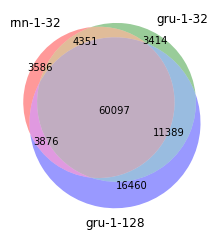

In [6]:
venn3(sets.values(), sets.keys());